In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential

In [3]:
print("The number of images with facemask: ",len(os.listdir('experiements/data/with_mask')))
print("The number of images without facemask: ",len(os.listdir('experiements/data/without_mask')))

The number of images with facemask:  690
The number of images without facemask:  686


In [4]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    dataset = []
    
    for unitData in os.listdir(SOURCE):
        data = SOURCE + unitData
        if(os.path.getsize(data) > 0):
            dataset.append(unitData)
        else:
            print('Skipped ' + unitData)
            print('Invalid file i.e zero size')
    
    train_set_length = int(len(dataset) * SPLIT_SIZE)
    test_set_length = int(len(dataset) - train_set_length)
    shuffled_set = random.sample(dataset, len(dataset))
    train_set = dataset[0:train_set_length]
    test_set = dataset[-test_set_length:]
       
    for unitData in train_set:
        temp_train_set = SOURCE + unitData
        final_train_set = TRAINING + unitData
        copyfile(temp_train_set, final_train_set)
    
    for unitData in test_set:
        temp_test_set = SOURCE + unitData
        final_test_set = TESTING + unitData
        copyfile(temp_test_set, final_test_set)

In [6]:
YES_SOURCE_DIR = "experiements/data/with_mask/"
TRAINING_YES_DIR = "experiements/train/with_mask/"
TESTING_YES_DIR = "experiements/test/with_mask/"
NO_SOURCE_DIR = "experiements/data/without_mask/"
TRAINING_NO_DIR = "experiements/train/without_mask/"
TESTING_NO_DIR = "experiements/test/without_mask/"

In [ ]:
split_size = .8
split_data(YES_SOURCE_DIR, TRAINING_YES_DIR, TESTING_YES_DIR, split_size)
split_data(NO_SOURCE_DIR, TRAINING_NO_DIR, TESTING_NO_DIR, split_size)

In [7]:
image_size = 150

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   #rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_generator = data_generator_with_aug.flow_from_directory(
        'experiements/train',
        target_size=(image_size, image_size),
        batch_size=15,
        class_mode='categorical')

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)
                                           #rescale=1.0/255)

validation_generator = data_generator_no_aug.flow_from_directory(
        'experiements/test',
        #batch_size=10,
        target_size=(image_size, image_size),
        class_mode='categorical')


Found 1100 images belonging to 2 classes.
Found 276 images belonging to 2 classes.


In [8]:
num_classes = 2

model = Sequential()
model.add(MobileNetV2(include_top=False, pooling='avg', weights='imagenet'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))


model.layers[0].trainable = False

model.compile(optimizer='sgd', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])



C:\Users\91891\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [9]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

fit_stats = model.fit_generator(train_generator,
                              epochs=10,
                              validation_data=validation_generator,
                              callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 74 steps, validate for 9 steps
Epoch 1/10
73/74 [============================>.] - ETA: 0s - loss: 0.6017 - accuracy: 0.6912WARNING:tensorflow:From C:\Users\91891\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model-001.model\assets
74/74 [==============================] - 34s 454ms/step - loss: 0.5993 - accuracy: 0.6918 - val_loss: 0.1919 - val_accuracy: 0.9348
Epoch 2/10
74/74 [==============================] - 29s 387ms/step - loss: 0.3705 - accuracy: 0.8382 - val_loss: 0.1262 - val_accuracy: 0.9565
Epoch 3/10
74/74 [===

In [46]:
from IPython.display import Image, display
import scipy.misc
from collections import deque
Q = deque(maxlen=5)
model = load_model("mask_detection.h5")

Input image shape: (1, 150, 150, 3)


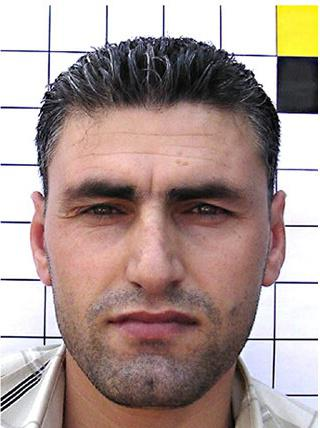

[[0.0130287 0.9869713]]


In [49]:
img_path = 'sample1.jpg'
img = load_img(img_path, target_size=(150, 150))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
# x = x/255.0
print('Input image shape:', x.shape)
display(Image(img_path))
preds = model.predict(x)
Q.append(preds)
results = np.array(Q).mean(axis=0)
l = np.argmax(results)
print(preds)

In [40]:
face_clsfr=cv2.CascadeClassifier('Face-Mask-Detection-master/Face-Mask-Detection-master/haarcascade_frontalface_default.xml')

In [ ]:
labels_dict={0:'with_mask', 1:'without_mask'}
color_dict={0:(0,255,0), 1:(0,0,255)}
advice_dict = {0:'You are safe', 1:'Please wear mask'}

#Q = deque(maxlen=3)

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('Face-Mask-Detection-master/Face-Mask-Detection-master/haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(150,150))
        #normalized=resized/255.0
        reshaped= np.reshape(resized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        reshaped = preprocess_input(reshaped)
        preds=model.predict(reshaped)
#         Q.append(preds)
#         result = np.array(Q).mean(axis=0)
        #print(result)
        
        label=np.argmax(preds,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        cv2.putText(im, advice_dict[label], (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 0, 0), 5)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    
    
    key = cv2.waitKey(10)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break

# Stop video
webcam.release()

# Close all started windows
cv2.destroyAllWindows()


In [45]:
model.save("mask_detection.h5")